In [ ]:
!pip install numpy==1.16.4
!pip install --upgrade pip
!pip install --upgrade tensorflow==2.0.0-rc1

In [2]:
from __future__ import print_function
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model, Sequential, save_model
from tensorflow.keras.layers import BatchNormalization, AveragePooling2D, MaxPooling2D, ZeroPadding2D, Conv2D
from tensorflow.keras.layers import Activation, Dropout, Flatten, Input, Dense
from tensorflow.keras.layers import concatenate
import tensorflow as tf
import pandas as pd
import numpy as np
import cv2

#
# ZFNet-MLP Mix Model
#   Model for the mixed data consists of Image, Numerical, Categorical data. For example..
#   1. Numeric/continuous values, such as age, heart rate, blood pressure
#   2. Categorical values, including gender and ethnicity
#   3. Image data, such as any MRI, X-ray, etc.
#

print(tf.__version__)
print(tf.executing_eagerly())

2.0.0-rc1
True


### Preprocessing
from alphabet to numeric, from size to numeric, from string style to numeric, and so on..

In [3]:
import json
JSON_FILE = './preprocess.json'
INPUT_PATH = './data.csv'
def load_mlp_attributes(inputPath):
    cols = ['col1','col2','col3','col4','col5','col6','col7','col8','col9','col10','col11','col12','col13','target','img_path']
    df = pd.read_csv(inputPath, sep=",", header=0)
    df.columns = cols

    with open(JSON_FILE) as json_file:
        convert_data = json.loads(json_file.read())
        df = df.replace({
            'col2': convert_data['col2'],
            'col3': convert_data['col3'],
            'col4': convert_data['col4'],
            'col5': convert_data['col5'],
            'col6': convert_data['col6']
        })
    return df
df = load_mlp_attributes(INPUT_PATH)

imgPathList = df['img_path']
df = df.drop(columns=['img_path'])

df.head()

,col1,col2,col3,col4,col5,col6,col7,col8,col9,col10,col11,col12,col13,target
0,1,1,1,1,1,1,19,0,0,0,0,0,100,15.2
1,2,1,1,1,1,1,19,0,0,0,0,0,100,15.7
2,3,1,1,1,2,1,23,0,0,0,0,0,100,23.7
3,4,1,1,1,1,1,23,0,0,0,0,0,100,24.8
4,5,1,1,0,3,1,23,0,0,0,0,0,100,None


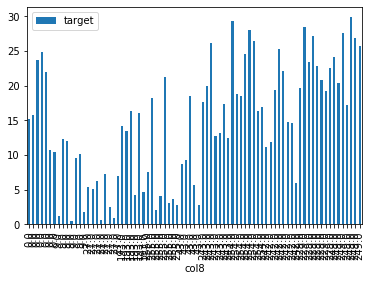

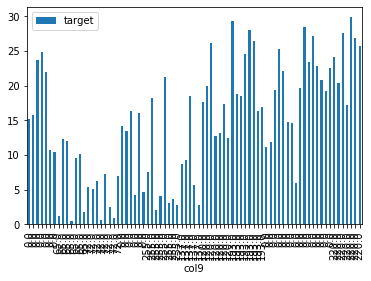

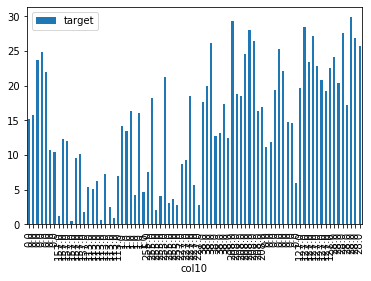

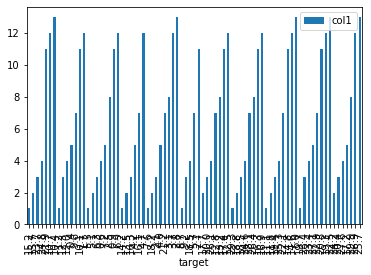

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt

confirming = df.drop(df[df['target'] == 'None'].index)
confirming = confirming.astype('float')
confirming.plot(x='col8',y='target', kind='bar')
confirming.plot(x='col9',y='target', kind='bar')
confirming.plot(x='col10',y='target', kind='bar')
plt.show()
confirming.plot(x='target',y='col1', kind='bar')
plt.show()

In [5]:
# print(df.dtypes)
with open("data_before_preprocess.csv", 'a', encoding='utf-8') as ofile:
    df.to_csv(ofile, index=False, encoding='utf-8')

In [6]:

def preprocess_mlp_attributes(df):
    categorical = ['col1','col2','col3','col4','col5','col6']
    continuous = ['col7','col8','col9','col10','col11','col12','col13']

    for col in categorical:
        one_hot = pd.get_dummies(df[col], prefix=col)
        df = df.drop(col, axis=1)
        df = df.join(one_hot)

    cs = MinMaxScaler()
    df[continuous] = cs.fit_transform(df[continuous])

    return df

df = preprocess_mlp_attributes(df)

# Remove No Use Data
df = df.drop(df[df['target'] == 'None'].index)

X = df.drop(columns=['target'])
y = df['target']
y = y.astype('float')


X.head()

,col7,col8,col9,col10,col11,col12,col13,col1_1,col1_2,col1_3,...,col3_1,col4_0,col4_1,col5_1,col5_2,col5_3,col5_4,col5_5,col5_7,col6_1
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,...,1,0,1,1,0,0,0,0,0,1
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0,...,1,0,1,1,0,0,0,0,0,1
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,1,...,1,0,1,0,1,0,0,0,0,1
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,...,1,0,1,1,0,0,0,0,0,1
7,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,...,1,1,0,1,0,0,0,0,0,1


In [7]:
def load_images(df, imgPathList):
    images = []

    for i in df.index.values:
        img = imgPathList[i]
        image = cv2.imread('./images/{}'.format(img))

        height, width, channels = image.shape
        if height > 896 and width > 896:
            y_d = int((height - 896) / 2)
            x_d = int((width - 896) / 2)
            image = image[y_d:height-y_d, x_d:width-x_d]
        image = cv2.resize(image, (224, 224))

        images.append(image)
    return np.array(images)

In [8]:
images = load_images(X, imgPathList)
images = images / 255.0

ymax = y.max()
y = y / ymax

X = np.asarray(X)
y = np.asarray(y)
images = np.asarray(images)

print(ymax)

29.9


In [9]:
test_size = 0.2
seed = 1
dropout = 0.5
X_train, X_test, y_train, y_test, Image_train, Image_test = train_test_split(X, y, images, test_size=0.1, random_state=seed)
X_train, X_valid, y_train, y_valid, Image_train, Image_valid = train_test_split(X_train, y_train, Image_train, test_size=test_size, random_state=seed)
# print(y_train)

In [10]:
#
# ZFNet
#
"""
(N - F) / stride + 1
e.g. N = 224, F = 7:
stride 2 => (224 - 7 + 1)/2 + 1 = 110 (1:Zero Padding)
Output size: 110
"""
def create_zfnet_model(width, height, depth, regression=True):
    model_input = Input(shape = (width, height, depth))
    x = Conv2D(kernel_size=(7,7), strides=(2,2), filters=96)(model_input)
    x = ZeroPadding2D(padding=(1,1))(x)
    x = MaxPooling2D(pool_size=(3,3), strides=(2,2))(x)
    x = BatchNormalization()(x)

    # This results shows aliasing artifacts
    x = Conv2D(kernel_size=(5,5), strides=(2,2), filters=256)(x)
    x = ZeroPadding2D(padding=(1,1))(x)
    x = MaxPooling2D(pool_size=(3,3), strides=(2,2))(x)
    x = BatchNormalization()(x)

    x = ZeroPadding2D(padding=(1,1))(x)
    # learn more specific pattern
    x = Conv2D(kernel_size=(3,3), strides=(1,1), filters=384)(x)

    x = ZeroPadding2D(padding=(1,1))(x)
    x = Conv2D(kernel_size=(3,3), strides=(1,1), filters=384)(x)

    x = ZeroPadding2D(padding=(1,1))(x)
    # This result shows entire objects with significant pose variation
    x = Conv2D(kernel_size=(3,3), strides=(1,1), filters=256)(x)
    x = MaxPooling2D(pool_size=(3,3), strides=(2,2))(x)
    x = Flatten()(x)

    x = Dense(units=4096, activation='relu')(x)
    x = Dropout(rate=dropout)(x)

    x = Dense(units=4096, activation='relu')(x)
    x = Dropout(rate=dropout)(x)

    if regression is True:
        x = Dense(units=n_class)(x)
        x = Activation('linear')
    else:
        x = Dense(units=16, activation='relu')(x)
        x = Dropout(rate=dropout)(x)

    return Model(inputs=model_input, outputs=x, name='ZFNet Model')


In [11]:
#
# MLP Model
#
def create_mlp_model(dim, regression=True):
    model_input = Input(shape = dim)
    print(model_input)
    x = Dense(units=16, activation='relu')(model_input)
    x = Dense(units=16, activation='relu')(x)
    if regression is True:
        x = Dense(units=1, activation='linear')(x)

    return Model(inputs=model_input, outputs=x, name='MLP Model')

In [12]:
mlp_model = create_mlp_model(X_train.shape[1], regression=False)
cnn_model = create_zfnet_model(224, 224, 3, regression=False)

combines = concatenate([mlp_model.output, cnn_model.output])

x = Dense(units=256, activation='relu')(combines)
x = Dense(units=1, activation='linear')(x)

model = Model(inputs=[mlp_model.input, cnn_model.input], outputs=x)
model.summary()


Tensor("input_1:0", shape=(None, 28), dtype=float32)
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 109, 109, 96) 14208       input_2[0][0]                    
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 111, 111, 96) 0           conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 55, 55, 96)   0           zero_padding2d[0][0]             
_________________________________________

training..
Train on 56 samples, validate on 15 samples
Epoch 1/25
56/56 - 22s - loss: 1746.3459 - val_loss: 1.0017
Epoch 2/25
56/56 - 20s - loss: 7.3251 - val_loss: 0.2314
Epoch 3/25
56/56 - 20s - loss: 1.1246 - val_loss: 1.7311
Epoch 4/25
56/56 - 20s - loss: 6.5297 - val_loss: 0.2967
Epoch 5/25
56/56 - 20s - loss: 0.4375 - val_loss: 0.2767
Epoch 6/25
56/56 - 20s - loss: 0.3212 - val_loss: 0.2605
Epoch 7/25
56/56 - 20s - loss: 0.3026 - val_loss: 0.2431
Epoch 8/25
56/56 - 20s - loss: 0.2820 - val_loss: 0.2254
Epoch 9/25
56/56 - 20s - loss: 0.2624 - val_loss: 0.2083
Epoch 10/25
56/56 - 20s - loss: 0.2412 - val_loss: 0.1926
Epoch 11/25
56/56 - 20s - loss: 0.2227 - val_loss: 0.1781
Epoch 12/25
56/56 - 20s - loss: 0.2040 - val_loss: 0.1651
Epoch 13/25
56/56 - 20s - loss: 0.1885 - val_loss: 0.1534
Epoch 14/25
56/56 - 20s - loss: 0.1727 - val_loss: 0.1433
Epoch 15/25
56/56 - 20s - loss: 0.1589 - val_loss: 0.1347
Epoch 16/25
56/56 - 20s - loss: 0.1462 - val_loss: 0.1273
Epoch 17/25
56/56 - 20s

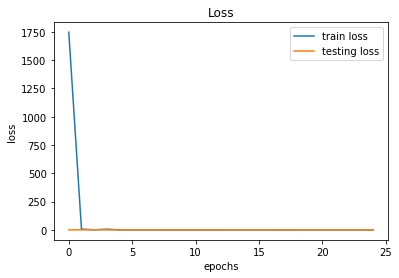

In [13]:
import tensorflow.keras.optimizers as optimizers
batch_size = 32
epochs = 25
optimizer='adam'
optimizer_dict = {'sgd': optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True),
                  'rmsprop': optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0),
                  'adagrad': optimizers.Adagrad(lr=0.01, epsilon=1e-08, decay=0.0),
                  'adadelta': optimizers.Adadelta(lr=1.0, rho=0.95, epsilon=1e-08, decay=0.0),
                  'adam': optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)}

model.compile(loss='mean_squared_error', optimizer=optimizer_dict[optimizer])

print('training..')
history = model.fit([X_train, Image_train], y_train,
    validation_data=([X_valid, Image_valid], y_valid),
    epochs=epochs,
    batch_size=batch_size,
    verbose=2)

plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='testing loss')
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

In [14]:
print('predicting..')
pred = model.predict([X_test, Image_test])
predicted = pred.flatten() * ymax
y_test = y_test * ymax

print(predicted)
print(y_test)

predicting..
[12.7403965 12.729767  11.962443  15.321645  12.9204035 12.208425
 12.971622  12.395714 ]
[ 6.   4.7  4.  20.8 17.4 12.5 26.4 27.6]


In [15]:
from sklearn.metrics import r2_score
print(r2_score(y_test, predicted))

0.011594648905154825


trainデータとvalidateデータにover-fittingしている。
epoch数が多すぎるかもしれないので減らして確認。

In [16]:
diff = predicted - y_test
percent_diff = abs(diff / y_test * 100)
mean = np.mean(percent_diff)
std = np.std(percent_diff)

print(mean)
print(std)

80.32698071202446
67.82187999707696
